In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap

import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

show_animation = False

In [10]:
print(datadir)
print("------------")
print(datacurr)

<xarray.Dataset>
Dimensions:    (latitude: 120, time: 8760, longitude: 212)
Coordinates:
  * latitude   (latitude) float32 40.6 40.65 40.69 40.73 ... 45.48 45.52 45.56
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 6.417 6.458 6.5 6.542 ... 15.13 15.17 15.21
Data variables:
    VMDR       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-04-23 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instan

In [66]:
# data = xr.open_dataset(r'med-cmcc-cur-an-fc-h_1637664022632.nc')
datadir = xr.open_dataset(r'wavedirtot.nc')
datacurr = xr.open_dataset(r'currentgiugdic2021tot.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = datacurr.variables['lat'][:]
lons = datacurr.variables['lon'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = datacurr.variables['time'][:]
wavedir = datadir.variables['VMDR'][:]
# wave = daa.variables['VHM0'][:]
datacurr

<xarray.Dataset>
Dimensions:  (depth: 1, time: 5136, lat: 120, lon: 212)
Coordinates:
  * depth    (depth) float32 1.018
  * lon      (lon) float32 6.417 6.458 6.5 6.542 ... 15.08 15.12 15.17 15.21
  * time     (time) datetime64[ns] 2021-06-01T00:30:00 ... 2021-12-31T23:30:00
  * lat      (lat) float32 40.6 40.65 40.69 40.73 ... 45.44 45.48 45.52 45.56
Data variables:
    vo       (time, depth, lat, lon) float32 ...
    uo       (time, depth, lat, lon) float32 ...
Attributes:
    title:                           Horizontal Velocity (3D) - Hourly Mean
    FROM_ORIGINAL_FILE__field_type:  hourly_mean_centered_at_time_field
    source:                          MFS EAS6
    institution:                     Centro Euro-Mediterraneo sui Cambiamenti...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    references:                      Clementi, E., Aydogdu, A., Goglio, A. C....
    comment:                         Please check in CMEMS catalogue the INFO...
    Conventions:                     CF-1.0
    bulletin_date:                   20220423
    bulletin_type:                   forecast
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [32]:
# general basemap of Italy configuration space
mp = Basemap(projection='merc',
             llcrnrlon=6.4166675,  
             llcrnrlat=40.604168, 
             urcrnrlon=15.208334, 
             urcrnrlat=45.5625,  
             resolution='f') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)

x_min, y_min = mp(8.958334, 41.354168) 
x_max, y_max = mp(11.500001, 43.270832)   

# mp2 = Basemap(projection='merc',
#              llcrnrlon=8.958334,  
#              llcrnrlat=41.354168, 
#              urcrnrlon=11.500001, 
#              urcrnrlat=43.270832,  
#              resolution='f') # f

In [50]:
u0 = datacurr.variables['uo'][:,0,:,:] # I care of sea current at surface, depth=0
v0 = datacurr.variables['vo'][:,0,:,:]
speed = np.hypot(u0, v0)

speed_slice_current = [[] for i in range(24)]
speed_u = [[] for i in range(24)]
speed_v = [[] for i in range(24)]
for i in range(24):
    speed_slice_current[i] = speed[i][268:315, 630:692]
    speed_u[i] = u0[i][268:315, 630:692]
    speed_v[i] = v0[i][268:315, 630:692]
# speed_slice = speed[0][268:315, 630:692]

In [18]:
u1 = np.array(speed_u)
v1 = np.array(speed_v)

# sx = 9.458334 
# sy = 41.645832
# gx = 11.041668 # 10.583334 
# gy = 42.520832 #42.729168   # 28
# sx_init, sy_init = mp2(sx, sy)
# gx_a, gy_a = mp2(gx, gy)

In [58]:
yearmean = datacurr.resample(time='1Y').mean(dim='time')
u0year = yearmean.variables['uo'][:,0,:,:]
v0year = yearmean.variables['vo'][:,0,:,:]

speed = np.hypot(u0year,v0year)
u1 = np.array(u0year)
v1 = np.array(v0year)

In [72]:
yearmeandir = datadir.resample(time='1Y').mean(dim='time')
wavediryear = yearmeandir.variables['VMDR'][:]
def decompose_wind_direction(wdir_deg):
    """generate the u/v rectangular components from wind directions
    """
    wdir_rad = wdir_deg * np.pi / 180
    u = -np.sin(wdir_rad)
    v = -np.cos(wdir_rad)
    return u, v

u_wav, v_wav = decompose_wind_direction(wavediryear)
u_wav = np.array(u_wav)
v_wav = np.array(v_wav)

<ipython-input-124-c7e674793189>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, speed[0], cmap='jet')
<ipython-input-124-c7e674793189>:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mp.quiver(x[points], y[points], u1[k][points], v1[k][points], width=0.002,scale=8, color='black', label='Current direction')
<ipython-input-124-c7e674793189>:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

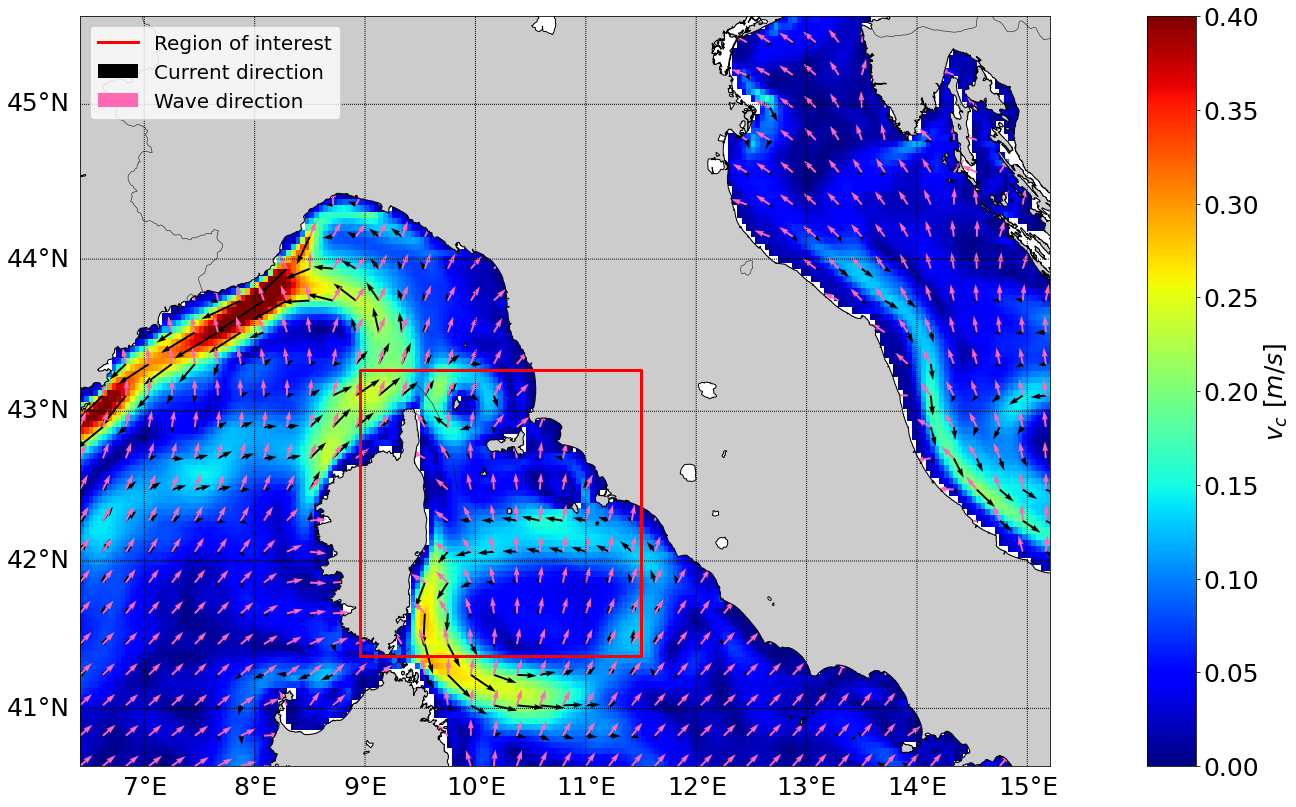

In [124]:
# x_min, y_min = mp(8.958334, 41.354168)    # lons.values[650], lats.values[268] 
# x_max, y_max = mp(11.500001, 43.270832)   # lons.values[711], lats.values[314]

# xspace = lons.values[630:692]
# yspace = lats.values[268:315]
# xs, ys = np.meshgrid(xspace, yspace)
# xs_, ys_ = mp2(xs, ys)


yy = np.arange(0, y.shape[0], 5)
xx = np.arange(0, x.shape[1], 5)
points = np.meshgrid(yy, xx)

k = 0
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# plt.plot(sx_init, sy_init, ">k", markersize=40)
# plt.plot(gx_a, gy_a, "Xr", markersize=20)
c_scheme = mp.pcolor(x, y, speed[0], cmap='jet')
mp.quiver(x[points], y[points], u1[k][points], v1[k][points], width=0.002,scale=8, color='black', label='Current direction')
mp.quiver(x[points], y[points], u_wav[k][points], v_wav[k][points], width=0.002,color='hotpink', label='Wave direction')
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
# cbar = mp2.colorbar(c_scheme, location='right', pad='10%')
cbar = mp.colorbar(c_scheme, location='right', pad='10%')
mp.drawmeridians(np.arange(6,16,1.0),labels=[0,0,0,1], fontsize=25) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0], fontsize=25) #latitudes
axtik = cbar.ax.get_yticks().tolist()
for i in range(len(axtik)):
    axtik[i] = round(axtik[i],1)
cbar.ax.set_yticklabels(axtik, fontsize=25)
plt.clim([0, 0.4])
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-", color="red", linewidth=3, label='Region of interest')
cbar.set_label('$v_c$ $[m/s]$', fontsize=25)
ax.legend(prop={"size":20}, loc="upper left")
# plt.title('Current')
plt.savefig('wavedircurr2021.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# hour = 0
# hours = np.arange(0, 24)
# for i in hours:
# #     c_scheme = mp2.pcolor(xs_, ys_, speed_slice_current[i], cmap='jet')
#     mp2.quiver(xs_[points], ys_[points], u1[i][points], v1[i][points],  width=0.002, color='b') # w
#     mp2.fillcontinents()
#     mp2.drawcoastlines()
#     mp2.drawstates()
#     mp2.drawcountries()
# #     cbar = mp.colorbar(c_scheme, location='right', pad='10%')
# #     cbar.set_label('$v_c$ $[m/s]$')
#     plt.title('Sea Surface Current Velocity on 23-11-2021 ' + str(hour) + ':30')
#     plt.savefig(r'.\Images' + '\\arrow_currentwobar' + str(hour) + '.png', dpi=500)
#     hour = i+1
#     plt.clf()
    
# plt.show()

In [55]:
s1x, s1y = mp2(lons.values[12], lats.values[7])  # start
g1x, g1y = mp2(lons.values[50], lats.values[28]) # Argentario
g2x, g2y = mp2(lons.values[39], lats.values[33]) # Elba

# Limit cycles APF

In [409]:
data = xr.open_dataset(r'currentaprildic.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# wave = daa.variables['VHM0'][:]
data

<xarray.Dataset>
Dimensions:  (depth: 1, time: 6600, lat: 47, lon: 62)
Coordinates:
  * depth    (depth) float32 1.018
  * lon      (lon) float32 8.958 9.0 9.042 9.083 ... 11.38 11.42 11.46 11.5
  * time     (time) datetime64[ns] 2021-04-01T00:30:00 ... 2021-12-31T23:30:00
  * lat      (lat) float32 41.35 41.4 41.44 41.48 ... 43.15 43.19 43.23 43.27
Data variables:
    vo       (time, depth, lat, lon) float32 ...
    uo       (time, depth, lat, lon) float32 ...
Attributes:
    title:                           Horizontal Velocity (3D) - Hourly Mean
    FROM_ORIGINAL_FILE__field_type:  hourly_mean_centered_at_time_field
    source:                          MFS EAS6
    institution:                     Centro Euro-Mediterraneo sui Cambiamenti...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    references:                      Clementi, E., Aydogdu, A., Goglio, A. C....
    comment:                         Please check in CMEMS catalogue the INFO...
    Conventions:                     CF-1.0
    bulletin_date:                   20220207
    bulletin_type:                   forecast
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [410]:
xspace = lons.values
yspace = lats.values
xs, ys = np.meshgrid(xspace, yspace)
xs_, ys_ = mp(xs, ys)

daymean = data.resample(time='1D').mean(dim='time')
monthmean = data.resample(time='1M').mean(dim='time')
yearmean = data.resample(time='1Y').mean(dim='time')

u0hour = data.variables['uo'][:,0,:,:]
v0hour = data.variables['vo'][:,0,:,:]
u0day = daymean.variables['uo'][:,0,:,:]
v0day = daymean.variables['vo'][:,0,:,:]
u0month = monthmean.variables['uo'][:,0,:,:]
v0month = monthmean.variables['vo'][:,0,:,:]
u0year = yearmean.variables['uo'][:,0,:,:]
v0year = yearmean.variables['vo'][:,0,:,:]

speed = np.hypot(u0year,v0year)
u1 = np.array(u0year)
v1 = np.array(v0year)

yy = np.arange(0, ys_.shape[0], 1)
xx = np.arange(0, xs_.shape[1], 1)
points = np.meshgrid(yy, xx)

<ipython-input-416-88181e8e9cf8>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mp2.quiver(xs_[points], ys_[points], u1[0][points], v1[0][points], width=0.001, color='dodgerblue')


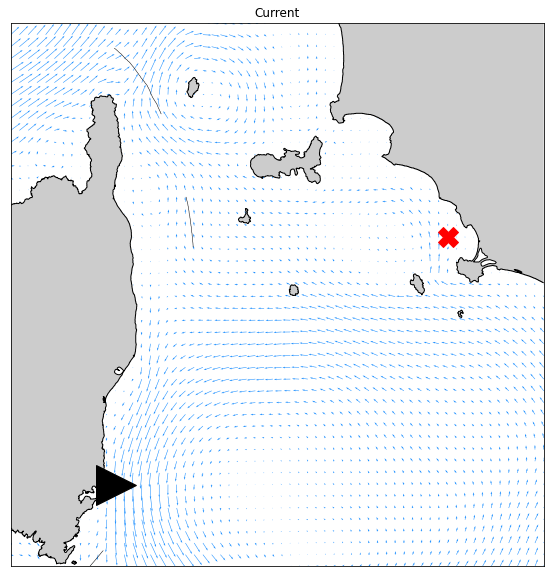

In [416]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# c_scheme = mp.pcolor(xs_, ys_, speed[0], cmap='jet')
mp2.quiver(xs_[points], ys_[points], u1[0][points], v1[0][points], width=0.001, color='dodgerblue')
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# cbar = mp2.colorbar(c_scheme, location='right', pad='10%')
# cbar.set_label('$v_c$ $[m/s]$')
plt.title('Current')
plt.show()

## Comparison waves and currents

In [437]:
data = xr.open_dataset('wave2021.nc')
july18 = data.sel(time='2021-07-18')
wave = july18.variables['VHM0'][:]

datac = xr.open_dataset(r'currentaprildic.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = datac.variables['lat'][:]
lons = datac.variables['lon'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = datac.variables['time'][:]

# print(data)
# print("----------")
# print(datac)

current = datac.sel(time='2021-09-10')
current

datav = xr.open_dataset('wavevel2021.nc')
datav

wavevel = datav.sel(time='2021-07-18')

datamarzo1 = xr.open_dataset('13marzowave.nc')
wave1 = datamarzo1.variables['VHM0'][:]
datamarzo2 = xr.open_dataset('13marzo2.nc')
wave2 = datamarzo2.variables['VHM0'][:]

In [349]:
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='f')

In [364]:
lon_mask, lat_mask = np.meshgrid(lons_mask, lats_mask)  # 1307 x 380
x_mask, y_mask = mp(lon_mask, lat_mask)

<ipython-input-366-bbfd30282e73>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x_mask, y_mask, mask)


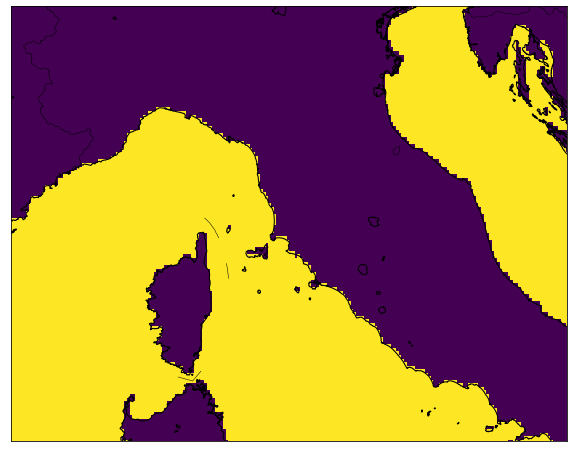

In [366]:
lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mp.pcolor(x_mask, y_mask, mask)
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
# plt.savefig("maskera.png", dpi=300)
plt.show()


<ipython-input-418-846578078240>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp2.pcolor(xs_, ys_, mask[268:315, 650:712])


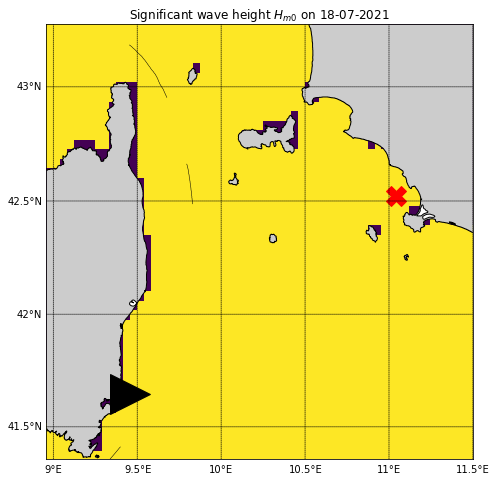

In [418]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
k =3
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.pcolor(xs_, ys_, mask[268:315, 650:712])
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
plt.title('Significant wave height $H_{m0}$ on 18-07-2021')
# plt.clim(0, 1.4)
plt.show()

In [438]:
u0 = current.variables['uo'][:,0,:,:] # I care of sea current at surface, depth=0
v0 = current.variables['vo'][:,0,:,:]
speed = np.hypot(u0, v0)

speed_slice_current = [[] for i in range(24)]
speed_u = [[] for i in range(24)]
speed_v = [[] for i in range(24)]
for i in range(24):
    speed_slice_current[i] = speed[i]
    speed_u[i] = u0[i]
    speed_v[i] = v0[i]

u1 = np.array(speed_u)
v1 = np.array(speed_v)


u0_wave = wavevel.variables['VSDX'][:,:,:]
v0_wave = wavevel.variables['VSDY'][:,:,:]
speed_w = np.hypot(u0_wave, v0_wave)
speed_slice_wave = [[] for i in range(24)]
speed_uw = [[] for i in range(24)]
speed_vw = [[] for i in range(24)]
for i in range(24):
    speed_slice_wave[i] = speed_w[i]
    speed_uw[i] = u0_wave[i]
    speed_vw[i] = v0_wave[i]
    
u1w = np.array(speed_uw)
v1w = np.array(speed_vw)

In [439]:
len(speed_w)

24

In [440]:
li = 0   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 24  # 15  18    18  17    15  - 17   23   12   12   15   18   15  
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i] = np.logical_xor(cost[i],binary_erosion(cost[i])) 
    
    
li = 0   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 24  # 15  18    18  17    15  - 17   23   12   12   15   18   15  
cost1 = np.zeros_like(wave1[li:le])
contour_raw_meteo = np.zeros_like(wave1[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost1[i] = 100 * (np.array(wave1[i+li]) > 0.8)
    contour_raw_meteo[i] = np.logical_xor(cost1[i],binary_erosion(cost1[i])) 
    
li = 0   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 24  # 15  18    18  17    15  - 17   23   12   12   15   18   15  
cost2 = np.zeros_like(wave2[li:le])
contour_raw_meteo = np.zeros_like(wave2[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost2[i] = 100 * (np.array(wave2[i+li]) > 0.8)
    contour_raw_meteo[i] = np.logical_xor(cost2[i],binary_erosion(cost2[i])) 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
k =20
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# c_scheme = mp2.pcolor(xs_, ys_, wave[k], cmap='jet')
c_scheme = mp2.pcolor(xs_, ys_, speed[k], cmap='jet')
# c_scheme = mp2.pcolor(xs_, ys_, cost2[k], cmap=ListedColormap(['white', 'red']))
# c_scheme = mp2.pcolor(xs_, ys_, speed_w[k], cmap='jet')
# mp2.quiver(xs_[points], ys_[points], u1w[k][points], v1w[k][points], width=0.002, color='dodgerblue')
mp2.quiver(xs_[points], ys_[points], u1[k][points], v1[k][points], width=0.002, color='k')
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
# mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
cbar = mp2.colorbar(c_scheme, location='right', pad='10%')
cbar.set_label('$v_c$ $[m/s]$') # $H_c$ $[m/s]$
plt.title('Sea surface current velocity $v_c$')
plt.savefig("currentpng.png", dpi=300)
# plt.clim(0, 0.7)
plt.show()

<ipython-input-446-0e95851e395c>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp2.pcolor(xs_, ys_, speed[k], cmap='jet')
<ipython-input-446-0e95851e395c>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mp2.quiver(xs_[points], ys_[points], u1[k][points], v1[k][points], width=0.002, color='k')


In [245]:
len(u1w)

24

In [327]:
hour = 0
hours = np.arange(0, 24)
for i in hours:
    plt.plot(sx_init, sy_init, ">k", markersize=10)
    plt.plot(gx_a, gy_a, "Xr", markersize=10)
#     c_scheme = mp2.pcolor(xs_, ys_, wave[i], cmap='jet')
#     c_scheme = mp2.pcolor(xs_, ys_, speed_slice_current[i], cmap='jet')
    c_scheme = mp2.pcolor(xs_, ys_, cost2[i], cmap=ListedColormap(['white', 'red']))
#     mp2.quiver(xs_[points], ys_[points], u1[i][points], v1[i][points], width=0.002, color='dodgerblue')
#     c_scheme = mp2.pcolor(xs_, ys_, speed_w[i], cmap='jet')
#     mp2.quiver(xs_[points], ys_[points], u1w[i][points], v1w[i][points], width=0.002, color='dodgerblue')
    mp2.fillcontinents()
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()
    mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
    mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
    cbar = mp.colorbar(c_scheme, location='right', pad='10%')
    cbar.set_label('$H_{m0}$ $[m]$')
    plt.clim(0, 1.4)
    plt.title('Significant wave height $H_{m0}$ on 13-03-2021 ' + str(hour) + ':00')
    plt.savefig(r'.\Images' + '\\marzo2_' + str(hour) + '.png', dpi=300)
    
    hour = i+1
    plt.clf()
    
plt.show()

<ipython-input-327-ed6cb51b7917>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp2.pcolor(xs_, ys_, cost2[i], cmap=ListedColormap(['white', 'red']))


<Figure size 432x288 with 0 Axes>

In [293]:
hour = 0
hours = np.arange(0, 24)
for i in hours:
    plt.plot(sx_init, sy_init, ">k", markersize=10)
    plt.plot(gx_a, gy_a, "Xr", markersize=10)
    c_scheme = mp2.pcolor(xs_, ys_, cost[i], cmap=ListedColormap(['white', 'red']))
    mp2.fillcontinents()
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()
    mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
    mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
#     mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
#     mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
    plt.title('Significant wave height $H_{m0} > 0.8$ $m$ on 18-07-2021 ' + str(hour) + ':00')
    plt.savefig(r'.\Images' + '\\wave1cost' + str(hour) + '.png', dpi=300)
    hour = i+1
    plt.clf()
plt.show()

<ipython-input-293-6115705a7af3>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp2.pcolor(xs_, ys_, cost[i], cmap=ListedColormap(['white', 'red']))


<Figure size 432x288 with 0 Axes>

In [16]:
import math
import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import time


class Vector2d:
    def __init__(self, x, y):
        self.deltaX = x
        self.deltaY = y
        self.length = -1
        self.direction = [0, 0]
        self.vector2d_share()

    def vector2d_share(self):
        if type(self.deltaX) == type(list()) and type(self.deltaY) == type(list()):
            deltaX, deltaY = self.deltaX, self.deltaY
            self.deltaX = deltaY[0] - deltaX[0]
            self.deltaY = deltaY[1] - deltaX[1]
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None
        else:
            self.length = math.sqrt(self.deltaX ** 2 + self.deltaY ** 2) * 1.0
            if self.length > 0:
                self.direction = [self.deltaX / self.length, self.deltaY / self.length]
            else:
                self.direction = None

    def __add__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX += other.deltaX
        vec.deltaY += other.deltaY
        vec.vector2d_share()
        return vec

    def __sub__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX -= other.deltaX
        vec.deltaY -= other.deltaY
        vec.vector2d_share()
        return vec

    def __mul__(self, other):
        vec = Vector2d(self.deltaX, self.deltaY)
        vec.deltaX *= other
        vec.deltaY *= other
        vec.vector2d_share()
        return vec

    def __truediv__(self, other):
        return self.__mul__(1.0 / other)

    def __repr__(self):
        return 'Vector deltaX:{}, deltaY:{}, length:{}, direction:{}'.format(self.deltaX, self.deltaY, self.length,
                                                                             self.direction)


class APF:

    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        """
        :param start: 起点
        :param goal: 终点
        :param obstacles: 障碍物列表，每个元素为Vector2d对象
        :param k_att: 引力系数
        :param k_rep: 斥力系数
        :param rr: 斥力作用范围
        :param step_size: 步长
        :param max_iters: 最大迭代次数
        :param goal_threshold: 离目标点小于此值即认为到达目标点
        :param is_plot: 是否绘图
        """
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01

    def attractive(self):
        att = (self.goal - self.current_pos) * self.k_att  # conical potential
        return att

    def repulsion(self):
        rep = Vector2d(0, 0)
        for obstacle in self.obstacles:
            # obstacle = Vector2d(0, 0)
            t_vec = self.current_pos - obstacle
            if t_vec.length > self.rr:
                pass
            else:
                rep += Vector2d(t_vec.direction[0], t_vec.direction[1]) * self.k_rep * (
                        1.0 / t_vec.length - 1.0 / self.rr) / (t_vec.length ** 2)  # 方向由障碍物指向机器人
        return rep

    def path_plan(self):
        while self.iters < self.max_iters and (self.current_pos - self.goal).length > self.goal_threshold:

            f_vec = self.attractive() + self.repulsion()
            self.current_pos += Vector2d(f_vec.direction[0], f_vec.direction[1]) * self.step_size
            self.iters += 1
            self.path.append([self.current_pos.deltaX, self.current_pos.deltaY])
#             print(self.current_pos.deltaX,self.current_pos.deltaY)
            if self.is_plot:
                plt.plot(self.current_pos.deltaX, self.current_pos.deltaY, '.b')
                plt.pause(self.delta_t)
        if (self.current_pos - self.goal).length <= self.goal_threshold:
            self.is_path_plan_success = True

In [36]:
# from APF3 import APF, Vector2d
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle
import random


def check_vec_angle(v1: Vector2d, v2: Vector2d):
    v1_v2 = v1.deltaX * v2.deltaX + v1.deltaY * v2.deltaY
    angle = math.acos(v1_v2 / (v1.length * v2.length)) * 180 / math.pi
    return angle


class APF_Improved(APF):
    def __init__(self, start: (), goal: (), obstacles: [], k_att: float, k_rep: float, rr: float,
                 step_size: float, max_iters: int, goal_threshold: float, is_plot=False):
        self.start = Vector2d(start[0], start[1])
        self.current_pos = Vector2d(start[0], start[1])
        self.goal = Vector2d(goal[0], goal[1])
        self.obstacles = [Vector2d(OB[0], OB[1]) for OB in obstacles]
        self.k_att = k_att
        self.k_rep = k_rep
        self.rr = rr  
        self.step_size = step_size
        self.max_iters = max_iters
        self.iters = 0
        self.goal_threshold = goal_threshold
        self.path = list()
        self.is_path_plan_success = False
        self.is_plot = is_plot
        self.delta_t = 0.01

    def repulsion(self):
        """
        斥力计算, 改进斥力函数, 解决不可达问题
        :return: 斥力大小
        """
        indexx = 0
        indexy = 0
        rep = Vector2d(0, 0) 
        for i in range(len(lons.values)):
            if np.allclose(self.current_pos.deltaX, lons.values[i], atol=.005, rtol=.005):
                indexx = i
        for i in range(len(lats.values)):
            if np.allclose(self.current_pos.deltaY, lats.values[i], atol=.005, rtol=.005):
                indexy = i
        if indexx and indexy and math.isnan(u1[0][indexy][indexx]) == False and math.isnan(v1[0][indexy][indexx]) == False:
            rep = Vector2d(u1[0][indexy][indexx], v1[0][indexy][indexx])*5
        else:
            rep = Vector2d(0,0)
#         print(rep)
#         for obstacle in self.obstacles:
#             obs_to_rob = self.current_pos - obstacle
#             rob_to_goal = self.goal - self.current_pos
#             obs_to_goal = self.goal - obstacle
#             if obs_to_rob.length > self.rr:  
#                 pass
#             else:
#                 rep = (Vector2d(obs_to_rob.deltaY, -obs_to_rob.deltaX) + Vector2d(obs_to_rob.deltaX, obs_to_rob.deltaY)*(self.rr**2 - obs_to_rob.deltaX**2 - obs_to_rob.deltaY**2))*50
        
#         for obstacle in self.obstacles:
#             obs_to_rob = self.current_pos - obstacle
#             rep = Vector2d(0, 0)

                
        return rep


In [37]:
grid_size = 0.04166
rr = grid_size*2
step_size, max_iters, goal_threshold = grid_size, 500, grid_size
step_size_ = grid_size*3

In [38]:
xspace = lons.values
yspace = lats.values
sx = xspace[12] #9.458334  
sy = yspace[7]  # 41.645832 
gx = xspace[50]  # 11.041668 
gy = yspace[28] # 42.520832
sx_init, sy_init = mp2(sx, sy)
gx_a, gy_a = mp2(gx, gy)

start = (sx, sy)
goal = (gx, gy)
obs = [[0,0]]

In [39]:
start_time = time.time()
apf = APF_Improved(start, goal, obs, 1, 0.8, rr, step_size, max_iters, goal_threshold, False)
apf.path_plan()
print("Computational time is {} seconds".format(time.time() - start_time))

path = apf.path
path_ = []
i = int(step_size_ / step_size)
while i < len(path):
    path_.append(path[i])
    i += int(step_size_ / step_size)
if path_[-1] != path[-1]:  # 添加最后一个点
    path_.append(path[-1])
# print('planed path points:{}'.format(path_))
if apf.is_path_plan_success:
    print('path plan success')
else:
    print('path plan failed')

Computational time is 0.7585313320159912 seconds
path plan success


In [40]:
pathgeox5 = []
pathgeoy5 = []
for i in range(len(path)):
    tempx, tempy = mp2(path[i][0],path[i][1])
    pathgeox5.append(tempx)
    pathgeoy5.append(tempy)

<ipython-input-42-055fa6b9d079>:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mp2.quiver(xs_[points], ys_[points], u1[k][points], v1[k][points], width=0.001, color='dodgerblue')


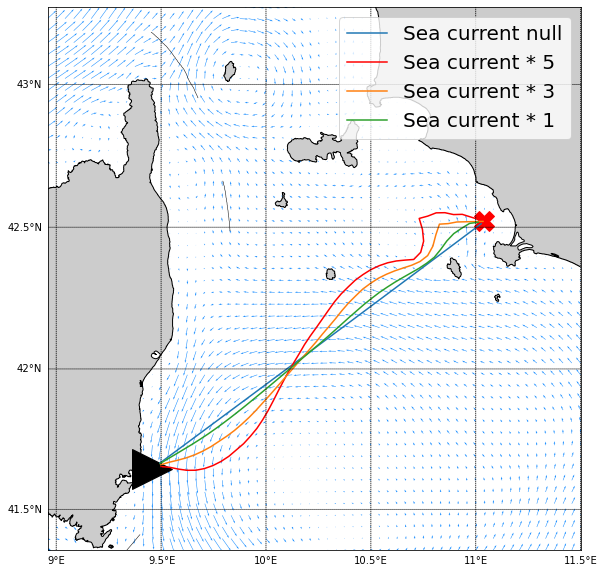

In [42]:
# pathgeox = []
# pathgeoy = []
# for i in range(len(path)):
#     tempx, tempy = mp2(path[i][0],path[i][1])
#     pathgeox.append(tempx)
#     pathgeoy.append(tempy)
#     pathgeo.append([tempx,tempy])
    
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
k=0
plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# c_scheme = mp.pcolor(xs_, ys_, speed_slice, cmap='jet')
plt.plot(pathgeox, pathgeoy, "-", markersize=10,label='Sea current null')
plt.plot(pathgeox5, pathgeoy5, "-r", markersize=10,label='Sea current * 5')
plt.plot(pathgeox3, pathgeoy3, "-", markersize=10,label='Sea current * 3')
plt.plot(pathgeox1, pathgeoy1, "-", markersize=10,label='Sea current * 1')
# for i in range(len(pathgeo)):
#     plt.plot(pathgeo[i][0], pathgeo[i][1],'.', color="k")
for i in range(len(obs)):
    plt.plot(obs[i][0], obs[i][1],'.', color="dodgerblue")
mp2.quiver(xs_[points], ys_[points], u1[k][points], v1[k][points], width=0.001, color='dodgerblue')
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
plt.savefig("current.png", dpi=300)
plt.show()

In [176]:
data = xr.open_dataset(r'wave_speed2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# wave = daa.variables['VHM0'][:]
data


<xarray.Dataset>
Dimensions:    (latitude: 47, time: 8760, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-02-07 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instantaneous_at_time_field
    title:                           Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [179]:
daymean = data.resample(time='1D').mean(dim='time')
monthmean = data.resample(time='1M').mean(dim='time')
yearmean = data.resample(time='1Y').mean(dim='time')

w1hour = data.variables['VSDX'][:,:,:]
w2hour = data.variables['VSDY'][:,:,:]
w1day = daymean.variables['VSDX'][:,:,:]
w2day = daymean.variables['VSDY'][:,:,:]
w1month = monthmean.variables['VSDX'][:,:,:]
w2month = monthmean.variables['VSDY'][:,:,:]
w1year = yearmean.variables['VSDX'][:,:,:]
w2year = yearmean.variables['VSDY'][:,:,:]

wspeed = np.hypot(w1year,w2year)
u1 = np.array(w1year)
v1 = np.array(w2year)

<ipython-input-181-b875eadcb0d0>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mp2.quiver(xs_[points], ys_[points], u1[0][points], v1[0][points], width=0.001, color='dodgerblue')


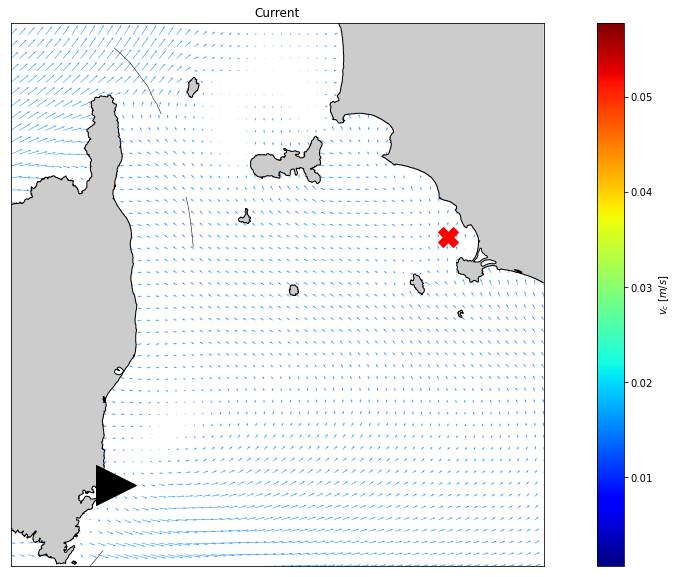

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

plt.plot(sx_init, sy_init, ">k", markersize=40)
plt.plot(gx_a, gy_a, "Xr", markersize=20)
# c_scheme = mp.pcolor(xs_, ys_, wspeed[0], cmap='jet')
mp2.quiver(xs_[points], ys_[points], u1[0][points], v1[0][points], width=0.001, color='dodgerblue')
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
cbar = mp2.colorbar(c_scheme, location='right', pad='10%')
cbar.set_label('$v_c$ $[m/s]$')
plt.title('Current')
plt.show()

In [517]:
import numpy as np
p1=np.array([6,20])
p2=np.array([20,20])
p3=np.array([8,20])
d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)

d

0.0